In [1]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt
#from fractions import Fraction

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Simulação eventos\\'

## Constantes

In [4]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 4200       # número de passos temporais. 2000
skip   = 1          # Taxa de pulos no dados salvos.

t = np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

In [5]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.

muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma   = 2
gamma_3 = 5/3

##  Parâmetros físicos pré-choques obtidos no evento do dia 01/12/2015

In [6]:
v1 = [-500.7491, 52.872524, -17.03108]                # km/s
B1 = [-3.197709, -5.1067386, -1.5899134]              # nT
n1 = 7.9405265                                        # cm^-3
T1 = 75.6668                                          # eV
# vetor normal ao plano de choque
n = [0.8855696, -0.0281544, -0.4636528]

## Transformações referentes aos valores normais e tangenciais 

### Módulo da velocidade na região pré-choque

In [7]:
round(np.linalg.norm(v1),3)          # km/s

503.821

In [8]:
v1n = np.abs(np.dot(v1,n)*1e3)                         # Velocidade pré-choque normal ao plano de choque        [m/s]
B1n = np.dot(B1,n)                                     # Campo magnético pré-choque normal ao plano de choque   

B1t = np.sqrt(np.linalg.norm(B1)**2 - B1n**2)*1e-9     # Campo magnético pré-choque tangente ao plano de choque [T]

B1u = np.array([0,0,B1t])                              # vetor B1t na direção z

### Velocidade pré-choque na direção do vetor normal n

In [9]:
round(v1n,3)     # m/s 

437040.266

### Campo magnético na direção perpendicular ao vetor normal n

In [10]:
round(B1t/1e-9, 3)   #nT

5.918

In [11]:
B1u           # vetor

array([0.00000000e+00, 0.00000000e+00, 5.91828819e-09])

### Parâmetros derivados

In [12]:
# derived parameters

Eu = -np.cross(np.array([0,v1n,0]),np.array([0,0,B1t]))     # electric field. The same on both sides.
p1 = 2*n1*1e6*1.3806e-23*(T1*1.1604e4)                      # thermal pressure in Pa (the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)*1e6                                        # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1t)    # thermal gyroradius in m.

In [13]:
print('{:.3e}'.format(m*me))   # Massa em kg

1.672e-27


In [14]:
print('{:.3e}'.format(np.abs(q)*1.602e-19))  # Carga em C

1.602e-19


In [15]:
round(R1,3)

212386.882

In [16]:
Eu

array([-0.00258653, -0.        , -0.        ])

In [17]:
em = 0.5*(rho1*(v1n**2)+B1t**2/(muo))+p1
    
zeta = ( (2*gamma*em-rho1*(v1n**2))+ np.sqrt((2*gamma*em-rho1*(v1n**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1n*B1t)**2/muo ) )/(2*rho1*(gamma+1)*v1n**2)

zeta_3 = ( (2*gamma_3*em-rho1*(v1n**2))+ np.sqrt((2*gamma_3*em-rho1*(v1n**2))**2 - 4*rho1*(gamma_3+1)*(gamma_3-2)*(v1n*B1t)**2/muo ) )/(2*rho1*(gamma_3+1)*v1n**2)

round(zeta,3), round(zeta_3,3)

(0.442, 0.356)

In [18]:
round(1/zeta,3), round(1/zeta_3,3)

(2.263, 2.812)

In [19]:
gamma, gamma_3

(2, 1.6666666666666667)

## Tabela com os parâmetros de entrada

In [20]:
zz_1 = round(1/zeta,3)
Tb_1 = [[dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma, round(zeta,3), zz_1 ],
        [dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma_3, round(zeta_3,3),round(1/zeta_3,3) ]
       ]

Tb_1

[[0.01, 437.04, 5.918, -2.587, 2, 0.442, 2.263],
 [0.01, 437.04, 5.918, -2.587, 1.6666666666666667, 0.356, 2.812]]

In [21]:
df1 = pd.DataFrame(Tb_1, columns = ['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $'], index=['2D', '3D'])
df1

,$\Delta t$,"$V_{1,n}$","$B_{1,t}$",$E_1$,$\gamma$,$r$,$\zeta $
2D,0.01,437.04,5.918,-2.587,2.000000,0.442,2.263
3D,0.01,437.04,5.918,-2.587,1.666667,0.356,2.812


## Conversão da tabela para latex

In [44]:
df1[['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $']].rename(
    columns = {'$\Delta t$':'$\Delta t \ [s]$',
               '$V_{1,n}$':'$\mathbf{V} \left[ \dfrac{km}{s} \right]$',
               '$B_{1,t}$':'$\mathbf{B} \ [nT]$',
               '$E_1$':'$\mathbf{E}_1 = \mathbf{E}_2 \ [mV]$',
               '$\gamma$':'$\gamma \left [\dfrac{C_P}{C_V} \right]$'  ,
               '$r$':'$r$', 
               '$\zeta $':r"$\zeta = 1/r$"}).to_latex('Parametros_de_entrada_01122015.tex', 
                                                                          caption = 'Parâmetros de entrada da simulação para o evento do dia 01/12/2015',
                                                                          column_format ='c|ccccccc',
                                                                          escape = False)

## Carregamento dos dados 

In [17]:
vxi = np.loadtxt(path_in+'Vx_MB.txt'); v_d = np.loadtxt(path_in+'Vy_MB.txt'); vzi = np.loadtxt(path_in+'Vz_MB.txt'); n = np.loadtxt(path_in+'n.txt')

# Simulação boris 2 D

In [ ]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); ry = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vy = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]); mu = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):  #Iterações para todos os elementos do vetor v_d
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = 0.0
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    v   = np.array([vx0,vy0,0])

    v1std = np.linalg.norm(v)
    
    #em = 0.5*(rho1*(v1std**2)+B1**2/(muo))+p1
    em = 0.5*(rho1*(v1std**2)+B1t**2/(muo))+p1
    
    #zeta = ( (2*gamma*em-rho1*(v1std**2))+ np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1)**2/muo ) )/(2*rho1*(gamma+1)*v1std**2)
    zeta = ( (2*gamma*em-rho1*(v1std**2))+ np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1t)**2/muo ) )/(2*rho1*(gamma+1)*v1std**2)
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1t))
    rL[0,i]=(m*me)*v1std/(np.abs(q*qe)*(B1t))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento (primeira iteração)

In [ ]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'2D\\'+'rx.txt', rx); np.savetxt(path_in+'2D\\'+'ry.txt', ry)  
np.savetxt(path_in+'2D\\'+'vx.txt', vx); np.savetxt(path_in+'2D\\'+'vy.txt', vy) 
np.savetxt(path_in+'2D\\'+'ek.txt', ek); np.savetxt(path_in+'2D\\'+'mu.txt', mu) ; np.savetxt(path_in+'2D\\'+'rL.txt', rL)

##  Carregamento

In [45]:
rx = np.loadtxt(path_in+'2D\\'+'rx.txt'); ry = np.loadtxt(path_in+'2D\\'+'ry.txt') 
#vx = np.loadtxt(path_in+'2D\\'+'vx.txt'); vy = np.loadtxt(path_in+'2D\\'+'vy.txt') 
#ek = np.loadtxt(path_in+'2D\\'+'ek.txt'); mu = np.loadtxt(path_in+'2D\\'+'mu.txt') ; rL = np.loadtxt(path_in+'2D\\'+'mu.txt')

## Gráficos 

In [47]:
y_p = 4.452251290409819

In [48]:
rx.shape

(4201, 50000)

<IPython.core.display.Javascript object>


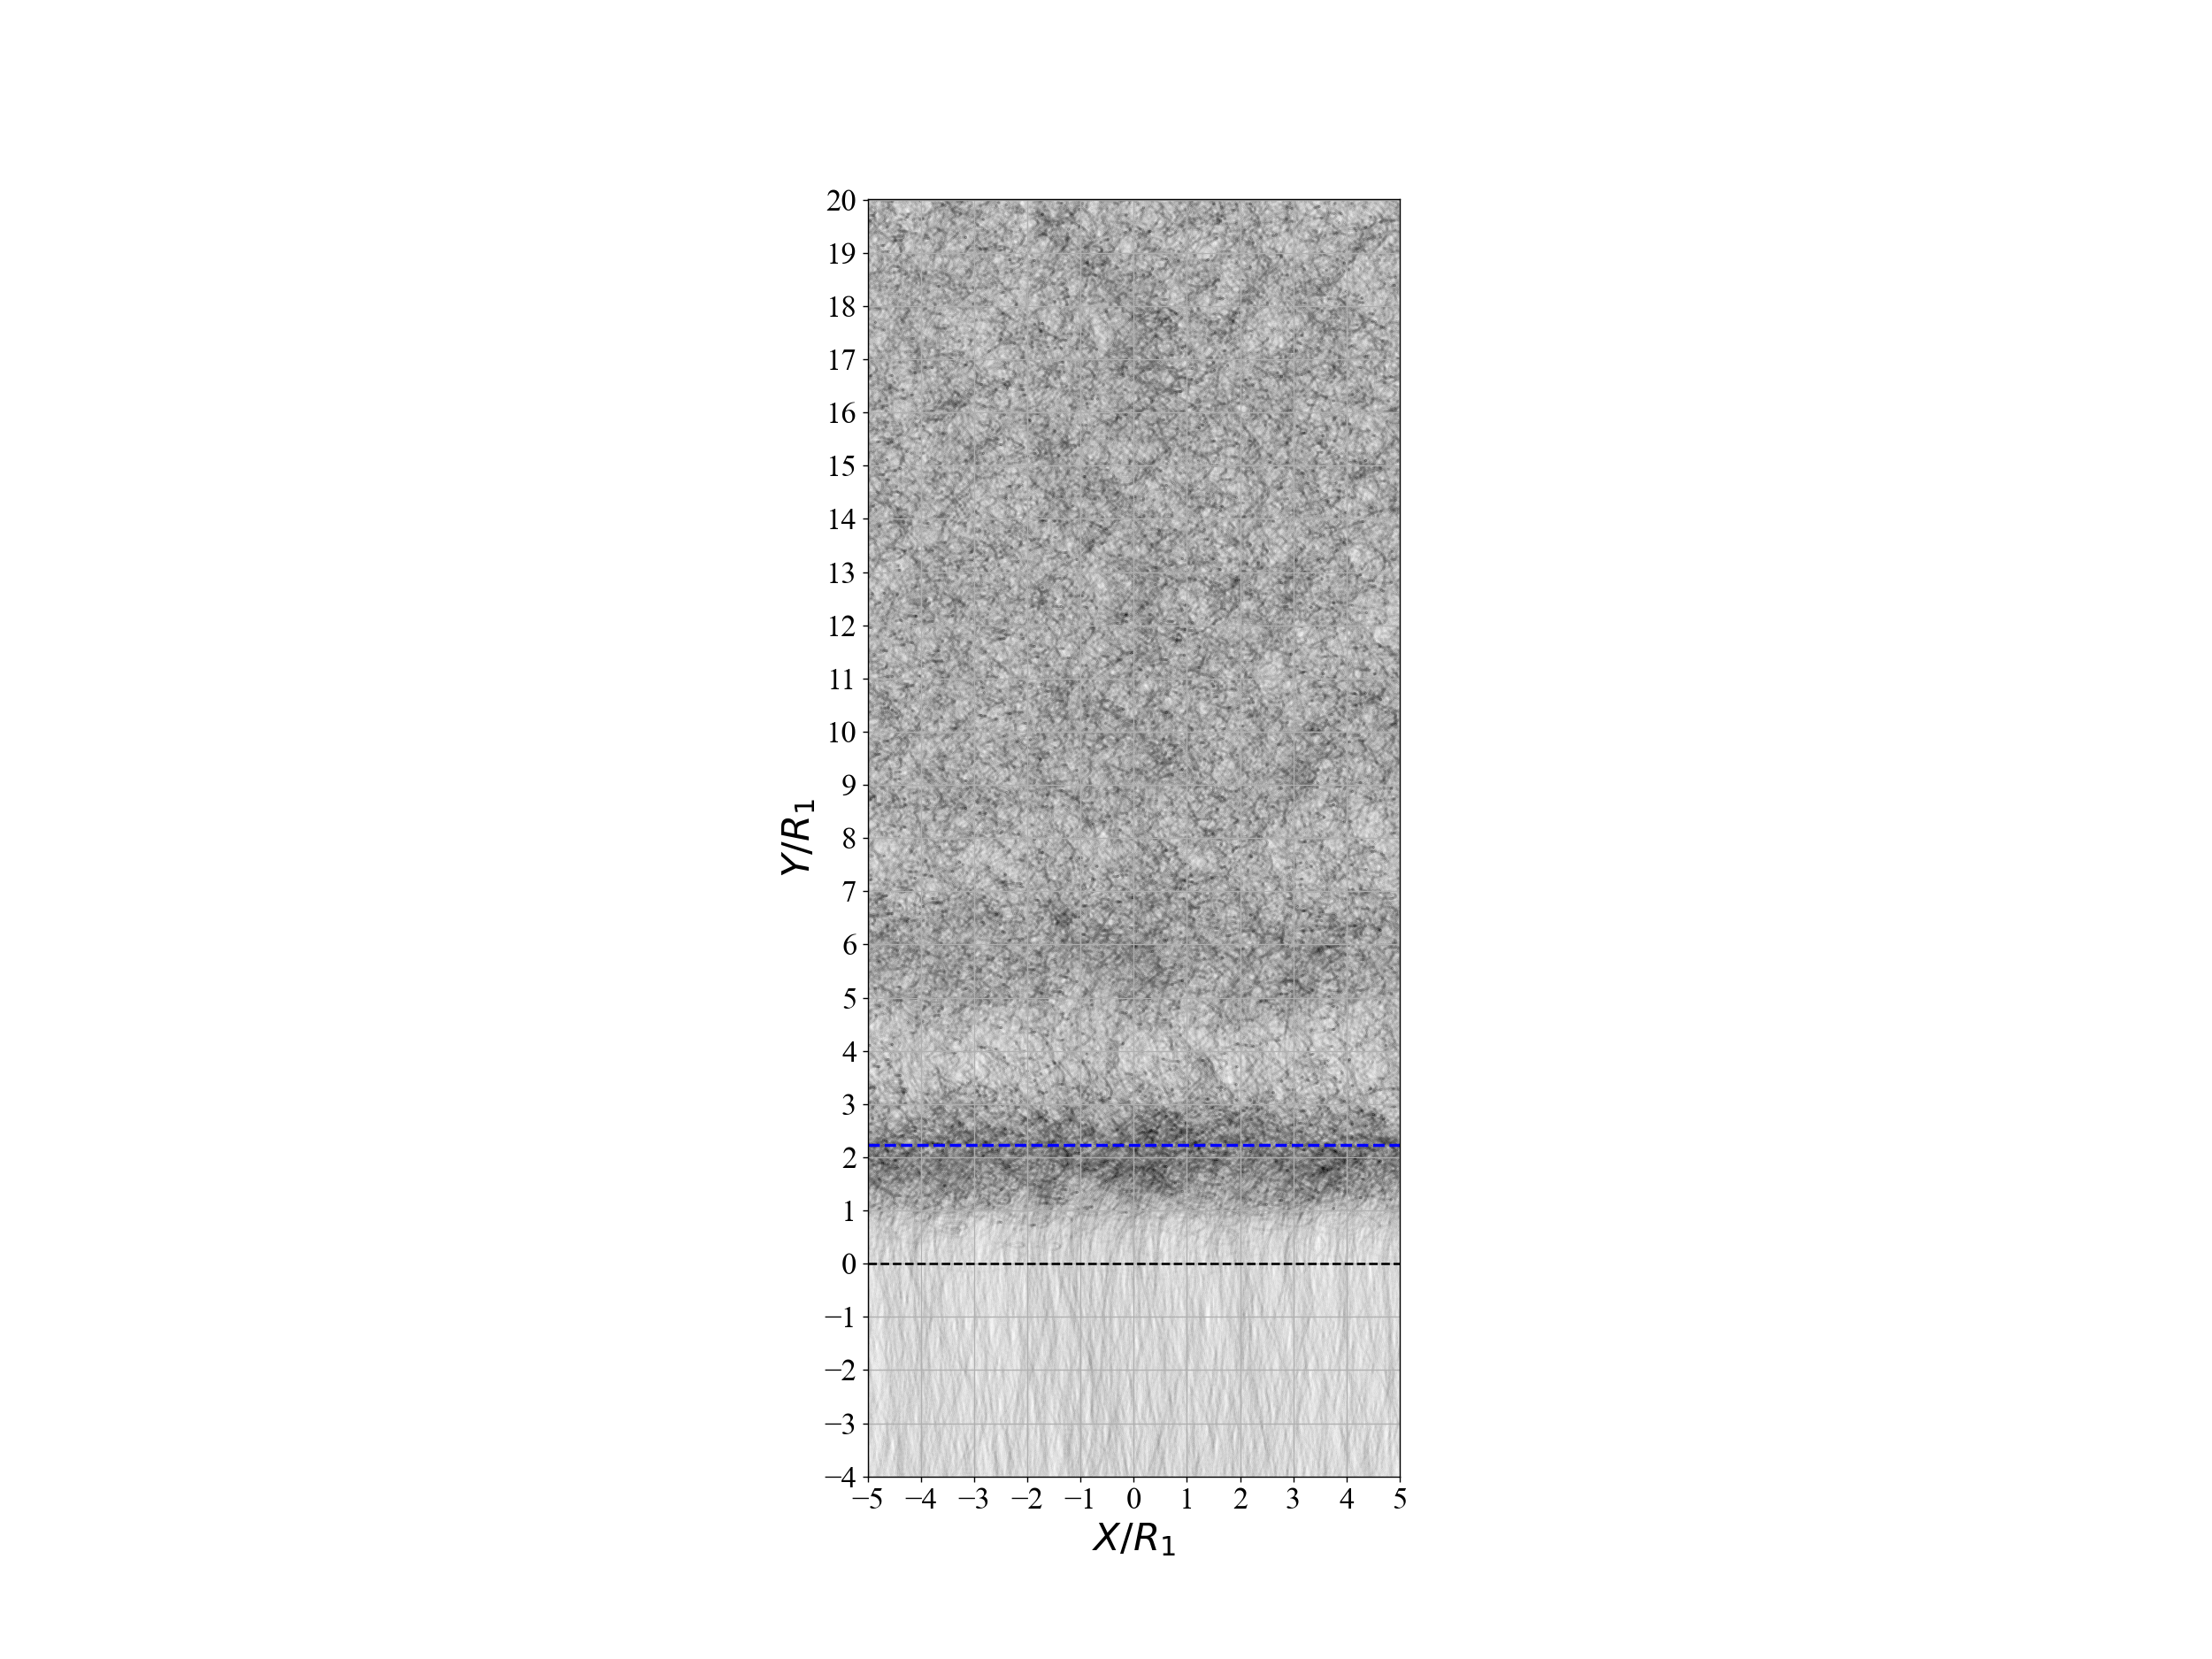

In [53]:
ynlim =2650
y0 = -4.0*R1 

nstep = 20

fig,ax = plt.subplots(1,1,figsize=(20,15))

#ax.scatter(rx[:ynlim,0:20000]/R1,ry[:ynlim,0:20000]/R1,s=0.0000005, color='k')
ax.scatter(rx[:ynlim,0:50000:nstep]/R1,ry[:ynlim,0:50000:nstep]/R1,s=0.00002, color='k')  #salvamento v1

for i in range(0,1):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--', lw=2)
    
ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([-4,20.01]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,20.01,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size= 25)
ax.tick_params(axis='both', which='major', labelsize = 20 )
ax.grid(axis='both')

ax.set_aspect(1)

#plt.savefig('MonteCarlo01122015_2D_v1.png',dpi=150, bbox_inches='tight',facecolor='w', edgecolor='w')

##plt.savefig('MonteCarlo01122015_2D.png', bbox_inches='tight',facecolor='w', edgecolor='w')



#plt.savefig('MonteCarlo01122015_2D_v5.png', bbox_inches='tight', facecolor='w', edgecolor='w')
#plt.savefig('MonteCarlo01122015_2D.eps', dpi = 300)

## Discretização 

In [28]:
rx.shape

(4201, 50000)

In [29]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

((2650, 50000), (2650, 50000))

In [30]:
# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0   
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 20
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

# Discretização 
x_i = int((x_2-x_1)/dx)
y_i = int((y_2-y_1)/dy)

rx_d = rx_d/R1; ry_d = ry_d/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))

x_size = np.arange(len(rx_d))
y_size = np.arange(len(rx_d[0,:]))

x_ii = np.arange(x_1, x_2, dx)
y_jj = np.arange(y_1, y_2, dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx_d[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry_d[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc  # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

## Salvamento 

In [31]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

np.savetxt(path_in+'2D\\'+'cc_01_32.txt', cc); 
np.savetxt(path_in+'2D\\'+'w_i_01_32.txt', w_i) 
np.savetxt(path_in+'2D\\'+'cvx_01_32.txt', cm_vx)
np.savetxt(path_in+'2D\\'+'cvy_01_32.txt', cm_vy)

## Carregamento 

In [22]:
cc    = np.loadtxt(path_in+'2D\\'+'cc_01_32.txt')
w_i   = np.loadtxt(path_in+'2D\\'+'w_i_01_32.txt') 
cm_vx = np.loadtxt(path_in+'2D\\'+'cvx_01_32.txt')
cm_vy = np.loadtxt(path_in+'2D\\'+'cvy_01_32.txt')

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0 
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 20     
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)
cc_n = cc/np.max(cc) 
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up+1])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up+1:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

# Contas

In [23]:
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:])/1e11 

F_1 = np.sqrt(f11**2+f21**2)
F_2 = np.sqrt(f12**2+f22**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

np.shape(F_X[:][0:i_up]), np.shape(F_X[:][i_up:i_dw]), f11, f12, f21, f22, v_1, v_2, aa, bb/aa

((40, 100),
 (200, 100),
 -0.7551403474911674,
 0.5538780672235168,
 34.69115877749212,
 34.60052723898515,
 423773.537836079,
 194384.51007961223,
 8.18818861273763,
 2.174146781846389)

In [24]:
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,0.320359,-0.076795,-0.074020,-0.166240,-0.147808,-0.068136,-0.030553,-0.332753,-0.436021,-0.517325,...,2.490056,2.678424,3.018351,2.642942,1.322736,4.499655,4.834364,6.881329,8.146173,5.480659
-4.85,0.737204,0.752440,0.625795,0.377436,0.197500,-0.063892,-0.170368,-0.449954,-0.719702,-1.049998,...,2.165673,3.468323,2.016942,3.627946,3.615778,4.478165,3.300288,7.541148,6.589065,6.599326
-4.75,-0.320558,0.075817,0.291785,0.234784,0.398218,-0.077032,0.033591,-0.139640,-0.248466,-0.140474,...,1.050845,2.840663,3.182601,3.650702,4.985846,4.221020,2.685498,5.547381,6.560283,5.692100
-4.65,0.215170,0.070820,-0.092183,-0.010339,-0.043734,0.019366,-0.524489,-0.494664,-0.408494,-0.421259,...,1.987718,2.267411,4.226352,4.728677,3.810146,2.807754,3.085319,7.181980,7.087960,6.501150
-4.55,0.580668,0.299652,0.117411,-0.205915,-0.891099,-0.688872,-0.463536,-0.445710,-0.749845,-0.760130,...,1.483103,4.089007,3.938254,3.315539,4.492209,2.974350,4.503492,5.672328,7.964398,6.458010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.273888,-0.278366,-0.589311,-0.724608,-0.514335,-0.459870,-0.390753,-0.360246,-0.446067,-0.536469,...,1.513694,3.964179,3.160015,3.180244,7.596631,5.941111,4.129804,5.407775,5.971719,8.333797
4.65,-0.242006,-0.389215,-0.149048,-0.059390,-0.087376,-0.336794,-0.590213,-0.655747,-0.576590,-0.575957,...,2.778769,3.119478,3.392169,3.725501,6.421915,6.612905,3.224584,4.934560,5.057846,7.812705
4.75,0.128179,0.232729,0.021732,-0.360863,-0.514814,-0.348636,-0.155069,-0.057265,0.025179,-0.195916,...,3.152043,1.805245,2.193268,4.682895,5.487622,4.456606,5.763497,5.019218,6.319211,7.185804
4.85,-0.468660,-0.288498,-0.264309,0.029684,0.072119,-0.029274,-0.002880,-0.156897,-0.434906,-0.169216,...,3.453977,3.342077,2.971015,1.979083,4.925418,5.944353,4.993551,5.945394,5.792683,5.257324


In [25]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,34.701819,34.703213,34.703219,34.702900,34.702983,34.703231,34.703285,34.701703,34.700559,34.699442,...,34.613849,34.599783,34.571787,34.602511,34.678081,34.410347,34.364922,34.014206,33.733644,34.267788
-4.85,34.695467,34.695140,34.697655,34.701246,34.702736,34.703239,34.702880,34.700381,34.695835,34.687410,...,34.635657,34.529547,34.644637,34.513141,34.514418,34.413151,34.546013,33.874031,34.072029,34.070043
-4.75,34.701818,34.703215,34.702071,34.702504,34.701013,34.703213,34.703282,34.703017,34.702409,34.703014,...,34.687384,34.586841,34.557054,34.510742,34.343271,34.445637,34.599234,34.257050,34.077582,34.233301
-4.65,34.702631,34.703226,34.703176,34.703297,34.703271,34.703293,34.699335,34.699773,34.700894,34.700741,...,34.646326,34.629146,34.444983,34.379624,34.493502,34.589528,34.565875,33.951997,33.971749,34.088912
-4.55,34.698440,34.702004,34.703100,34.702687,34.691856,34.696460,34.700202,34.700436,34.695196,34.694972,...,34.671592,34.461557,34.479110,34.544552,34.411320,34.575600,34.409845,34.236583,33.777023,34.097112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,34.702217,34.702182,34.698294,34.695732,34.699487,34.700251,34.701098,34.701428,34.700431,34.699151,...,34.670270,34.476139,34.559126,34.557271,33.861632,34.190965,34.456692,34.279365,34.185633,33.687783
4.65,34.702454,34.701115,34.702978,34.703247,34.703188,34.701664,34.698279,34.697102,34.698508,34.698518,...,34.591868,34.562809,34.537112,34.502747,34.103928,34.067409,34.553161,34.350677,34.332741,33.812432
4.75,34.703061,34.702518,34.703291,34.701422,34.699479,34.701547,34.702952,34.703251,34.703289,34.702745,...,34.559854,34.656312,34.633921,34.385889,34.266673,34.415949,34.221353,34.338409,34.123108,33.951187
4.85,34.700133,34.702099,34.702292,34.703285,34.703223,34.703286,34.703298,34.702943,34.700573,34.702886,...,34.530985,34.541995,34.575887,34.646820,34.351989,34.190402,34.342151,34.190221,34.216425,34.302761


## Gráfico da densidade númerica

<IPython.core.display.Javascript object>


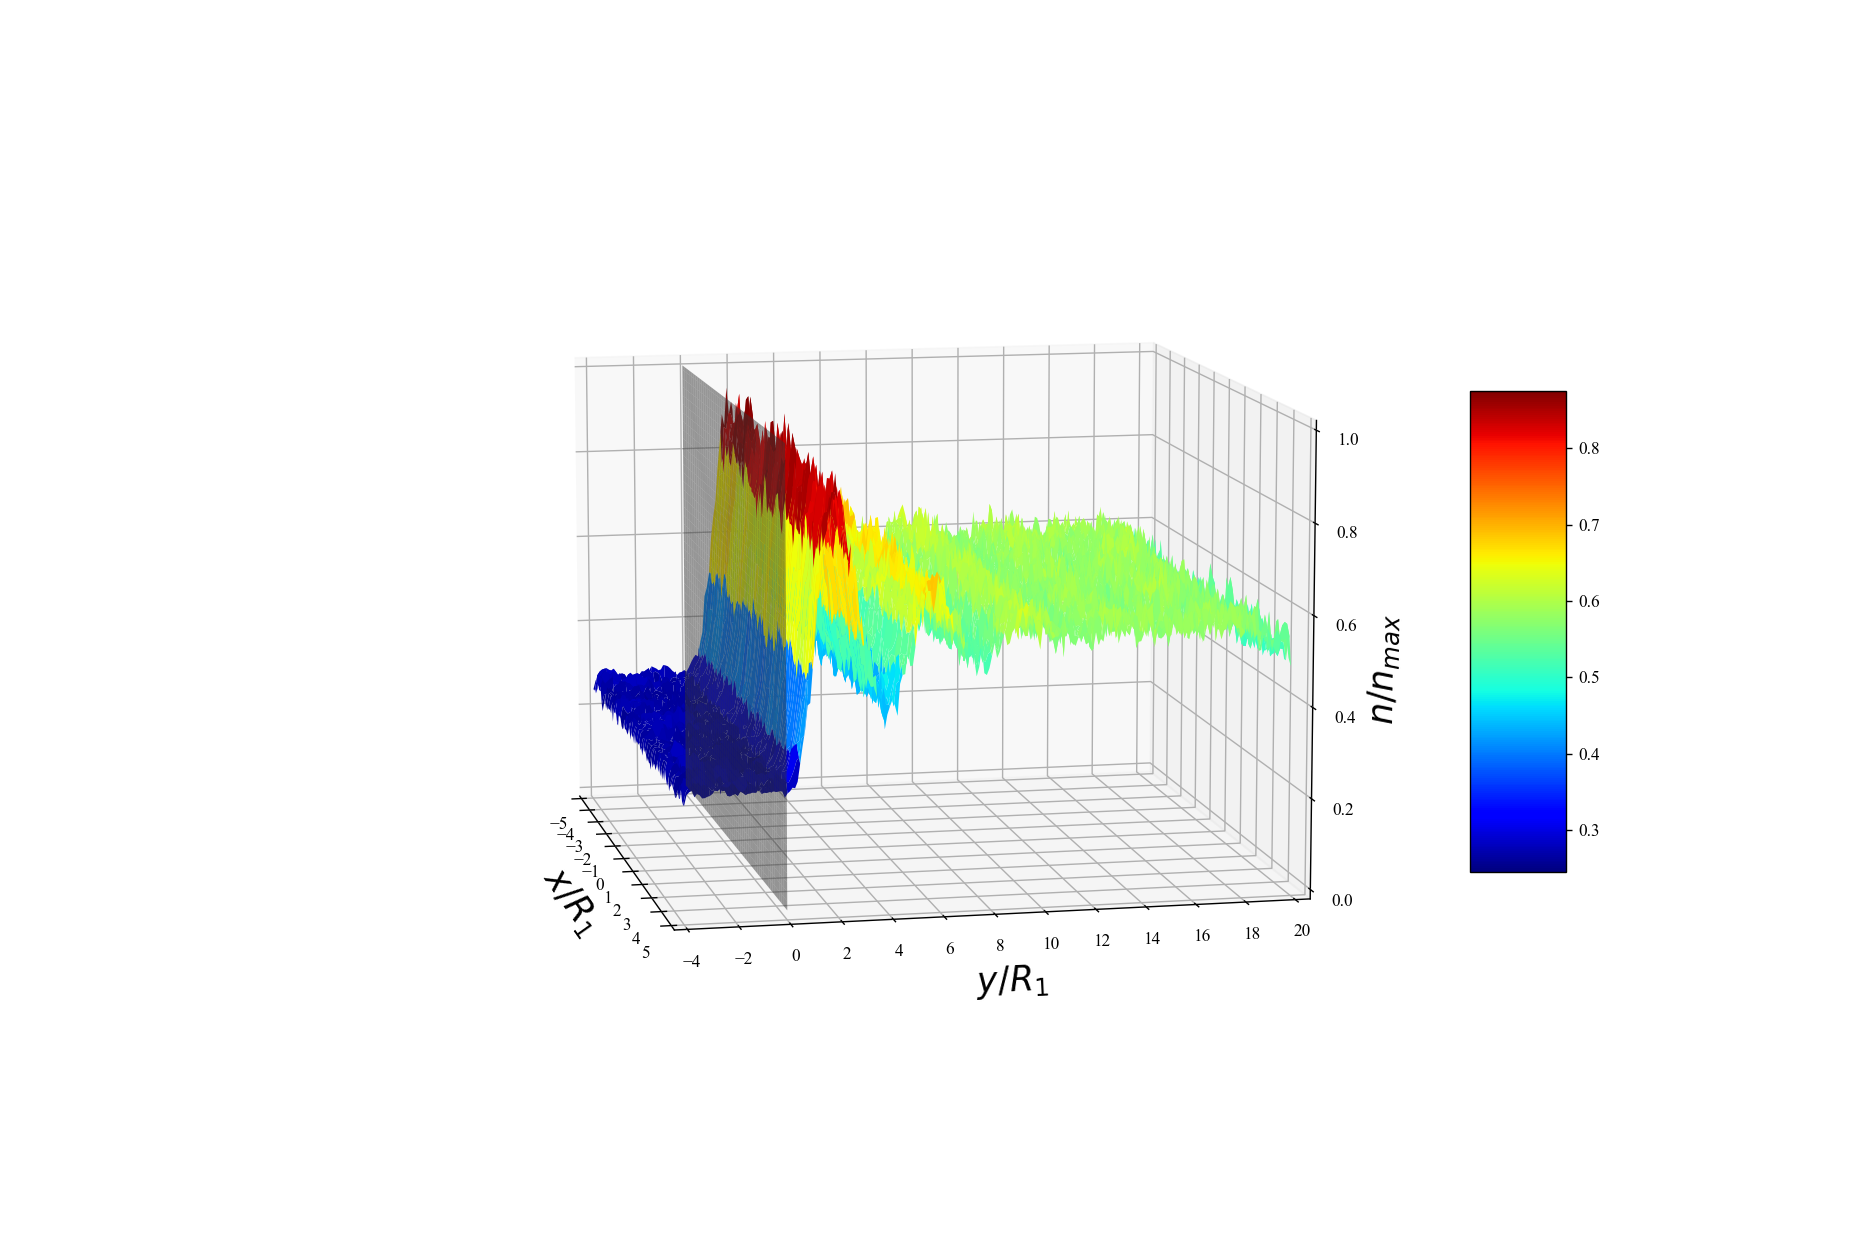

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,20.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-3.9,20.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4,20.1,2))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Estimativa dos erros

In [27]:
Z = w_i.T*cc.T/(dx*R1*dy*R1)   #Usando transposta

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [28]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,8.309696,8.263239,8.237437,8.222748,8.237480,8.194126,8.182452,8.317064,8.275777,8.216957,...,18.224748,18.282842,17.374336,17.870575,17.115398,16.709349,18.443144,17.454707,17.958318,17.300468
-4.85,8.310837,8.227513,8.182417,8.223935,8.228564,8.197680,8.251402,8.212544,8.172668,8.220451,...,17.729323,18.659091,18.455799,18.394973,18.828369,18.903439,19.229925,19.006805,17.304860,16.395457
-4.75,8.363340,8.317045,8.394035,8.323342,8.296037,8.292276,8.240512,8.295108,8.349243,8.256565,...,18.743658,17.028303,18.265651,18.154665,18.116011,17.873800,16.994391,17.478047,17.622869,16.543994
-4.65,8.215170,8.218877,8.147970,8.202784,8.267434,8.297774,8.335824,8.202500,8.165199,8.182913,...,18.597988,17.560953,18.864474,17.288689,17.034753,18.455644,18.035582,17.935194,18.097634,16.896966
-4.55,8.175683,8.175133,8.214965,8.244263,8.214348,8.204631,8.200944,8.252737,8.254795,8.221576,...,17.560809,16.706086,18.411138,18.101782,17.185488,18.229677,16.550057,16.786722,16.956128,17.801095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.248981,8.190349,8.162091,8.157796,8.168906,8.153821,8.167772,8.268489,8.353039,8.323207,...,17.951391,17.454357,18.222185,17.443877,17.565505,18.344731,18.694219,17.888135,17.158486,15.924008
4.65,8.233026,8.263089,8.310312,8.339803,8.303327,8.284801,8.299076,8.265409,8.257796,8.258677,...,18.036995,18.553944,18.996351,17.124833,17.628086,18.500098,18.420102,17.155456,18.120875,16.680718
4.75,8.152537,8.106140,8.117076,8.106738,8.185992,8.168758,8.176297,8.153772,8.205968,8.276958,...,18.127356,17.880102,18.231639,17.745552,17.355893,17.943034,17.171301,16.690063,17.593769,18.088726
4.85,8.428851,8.351808,8.340813,8.371305,8.374553,8.370615,8.297701,8.315830,8.251115,8.162052,...,17.744459,17.632079,17.753395,17.953421,17.500629,17.533921,18.850216,18.719919,18.334013,16.884956


In [29]:
n_mass[n_mass.columns[0:40]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,8.309696,8.263239,8.237437,8.222748,8.237480,8.194126,8.182452,8.317064,8.275777,8.216957,...,8.205384,8.191927,8.203367,8.220508,8.170310,8.068965,8.004096,8.036579,8.090562,8.061739
-4.85,8.310837,8.227513,8.182417,8.223935,8.228564,8.197680,8.251402,8.212544,8.172668,8.220451,...,8.112389,8.049248,7.997569,8.077947,8.043972,8.095316,8.059142,8.065937,8.133069,8.261234
-4.75,8.363340,8.317045,8.394035,8.323342,8.296037,8.292276,8.240512,8.295108,8.349243,8.256565,...,8.003317,8.096316,8.065418,8.035856,7.974513,8.040659,8.068515,8.092097,8.045298,8.029856
-4.65,8.215170,8.218877,8.147970,8.202784,8.267434,8.297774,8.335824,8.202500,8.165199,8.182913,...,8.168618,8.104373,8.074433,8.160613,8.106246,8.126532,8.100839,8.062132,8.055016,7.985733
-4.55,8.175683,8.175133,8.214965,8.244263,8.214348,8.204631,8.200944,8.252737,8.254795,8.221576,...,8.004318,8.018248,8.056350,8.062776,8.013049,7.953924,8.092977,8.059393,8.077157,8.036721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.248981,8.190349,8.162091,8.157796,8.168906,8.153821,8.167772,8.268489,8.353039,8.323207,...,8.089528,8.036146,8.007934,8.126235,8.063876,8.071815,8.095574,8.091222,8.116170,8.143072
4.65,8.233026,8.263089,8.310312,8.339803,8.303327,8.284801,8.299076,8.265409,8.257796,8.258677,...,8.228500,8.197711,8.156740,8.190713,8.037114,8.062388,8.075220,8.068343,8.133473,8.142563
4.75,8.152537,8.106140,8.117076,8.106738,8.185992,8.168758,8.176297,8.153772,8.205968,8.276958,...,8.116925,8.043083,8.020792,8.041720,8.078096,8.039063,8.023778,8.082048,8.116771,8.079158
4.85,8.428851,8.351808,8.340813,8.371305,8.374553,8.370615,8.297701,8.315830,8.251115,8.162052,...,8.115601,8.094564,8.085066,8.132074,8.191190,8.110952,8.114598,8.128398,8.161806,8.250501


In [30]:
#Número de partículas na região pré e pós choque.

np.sum(cc[:,:40]), np.sum(cc[:,40:])

(9999511.0, 108236661.0)

In [31]:
cc[:,:40].shape, cc[:,40:].shape

((100, 40), (100, 200))

In [32]:
cc[:,:40].shape

(100, 40)

In [33]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:40]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[40:]]))

d_up, d_dw

(8.188494384162057, 17.754192090705896)

### Estimativa do erro percentual 

In [34]:
# Região pré-choque
DVporV1 = (1*dx*dy)/(1*40)

Dn1     = DVporV1*np.sum(cc[:,0:40])

dn1 = 1/(np.sqrt(Dn1))

# Região pós-choque

DVporV2 = (1*dx*dy)/(1*200)

Dn2     = DVporV2*np.sum(cc[:,40:])    #cc[:,40:].shape

dn2 = 1/(np.sqrt(Dn2))

In [35]:
dn1, dn2

(0.020000489017934806, 0.013593390862537207)

In [36]:
nsig_up = n_mass[n_mass.columns[0:40]]*dn1   # 0.0200 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[40:]] *dn2   # 0.0136 é o erro percentual estimado para cada bin na região pós-choque

In [37]:
cc[:,:40].shape[0]*cc[:,:40].shape[1]

4000

In [38]:
cc[:,40:].shape[0]*cc[:,40:].shape[1]

20000

In [39]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])   # Propagação do erro pré-choque para o cálculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])   # Propagação do erro pós-choque

err_up, err_dw

(0.16377389200385406, 0.24133967253753189)

In [40]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 8.188  \pm 0.164 $

In [41]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.3} $'))

$n_2: 17.754  \pm 0.241 $

## Incerteza na densidade

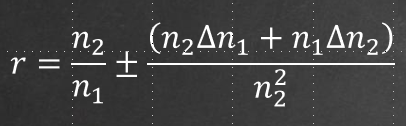

In [42]:
deln = (d_dw*err_up+d_up*err_dw)/(d_dw)**2
deln

0.01549399124094543

## Incerteza na velocidade 

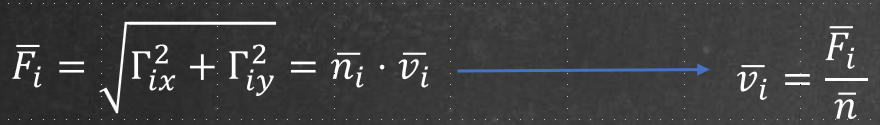

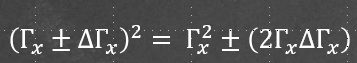

## Cálculo dos fluxos médios

In [43]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:40]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[40:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:40]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[40:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw

(-0.7551403474911675,
 0.5538780672235165,
 34.691158777492134,
 34.60052723898515)

## Estimativa das incerteza dos fluxos médios 

In [44]:
nfx_up = Fx[Fx.columns[0:40]]*dn1 
nfx_dw = Fx[Fx.columns[40:]] *dn2 

nfy_up = Fy[Fy.columns[0:40]]*dn1 
nfy_dw = Fy[Fy.columns[40:]] *dn2 

In [45]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])

errfx_up, errfx_dw, errfy_up, errfy_dw

(0.015748010496043477,
 0.0270057839345763,
 0.6938401401486638,
 0.47033849080939044)

## Região pré-choque 

In [46]:
f_upx = Fx_up**2  
f_upy = Fy_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy)
delf_up = (delf_upx + delf_upy)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(34.699, 0.694)

##  Região pós-choque

In [47]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy)
delf_dw = (delf_dwx + delf_dwy)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(34.605, 0.471)

## Incerteza nas velocidades

In [48]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(423757.713, 16950.894, 194911.489, 5300.772)

## Estimativa do r a partir das velocidades

In [49]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.174, 0.146)

In [50]:
v_up

4.237577134571128

In [51]:
round(v_up*1e2,3)

423.758

<IPython.core.display.Javascript object>


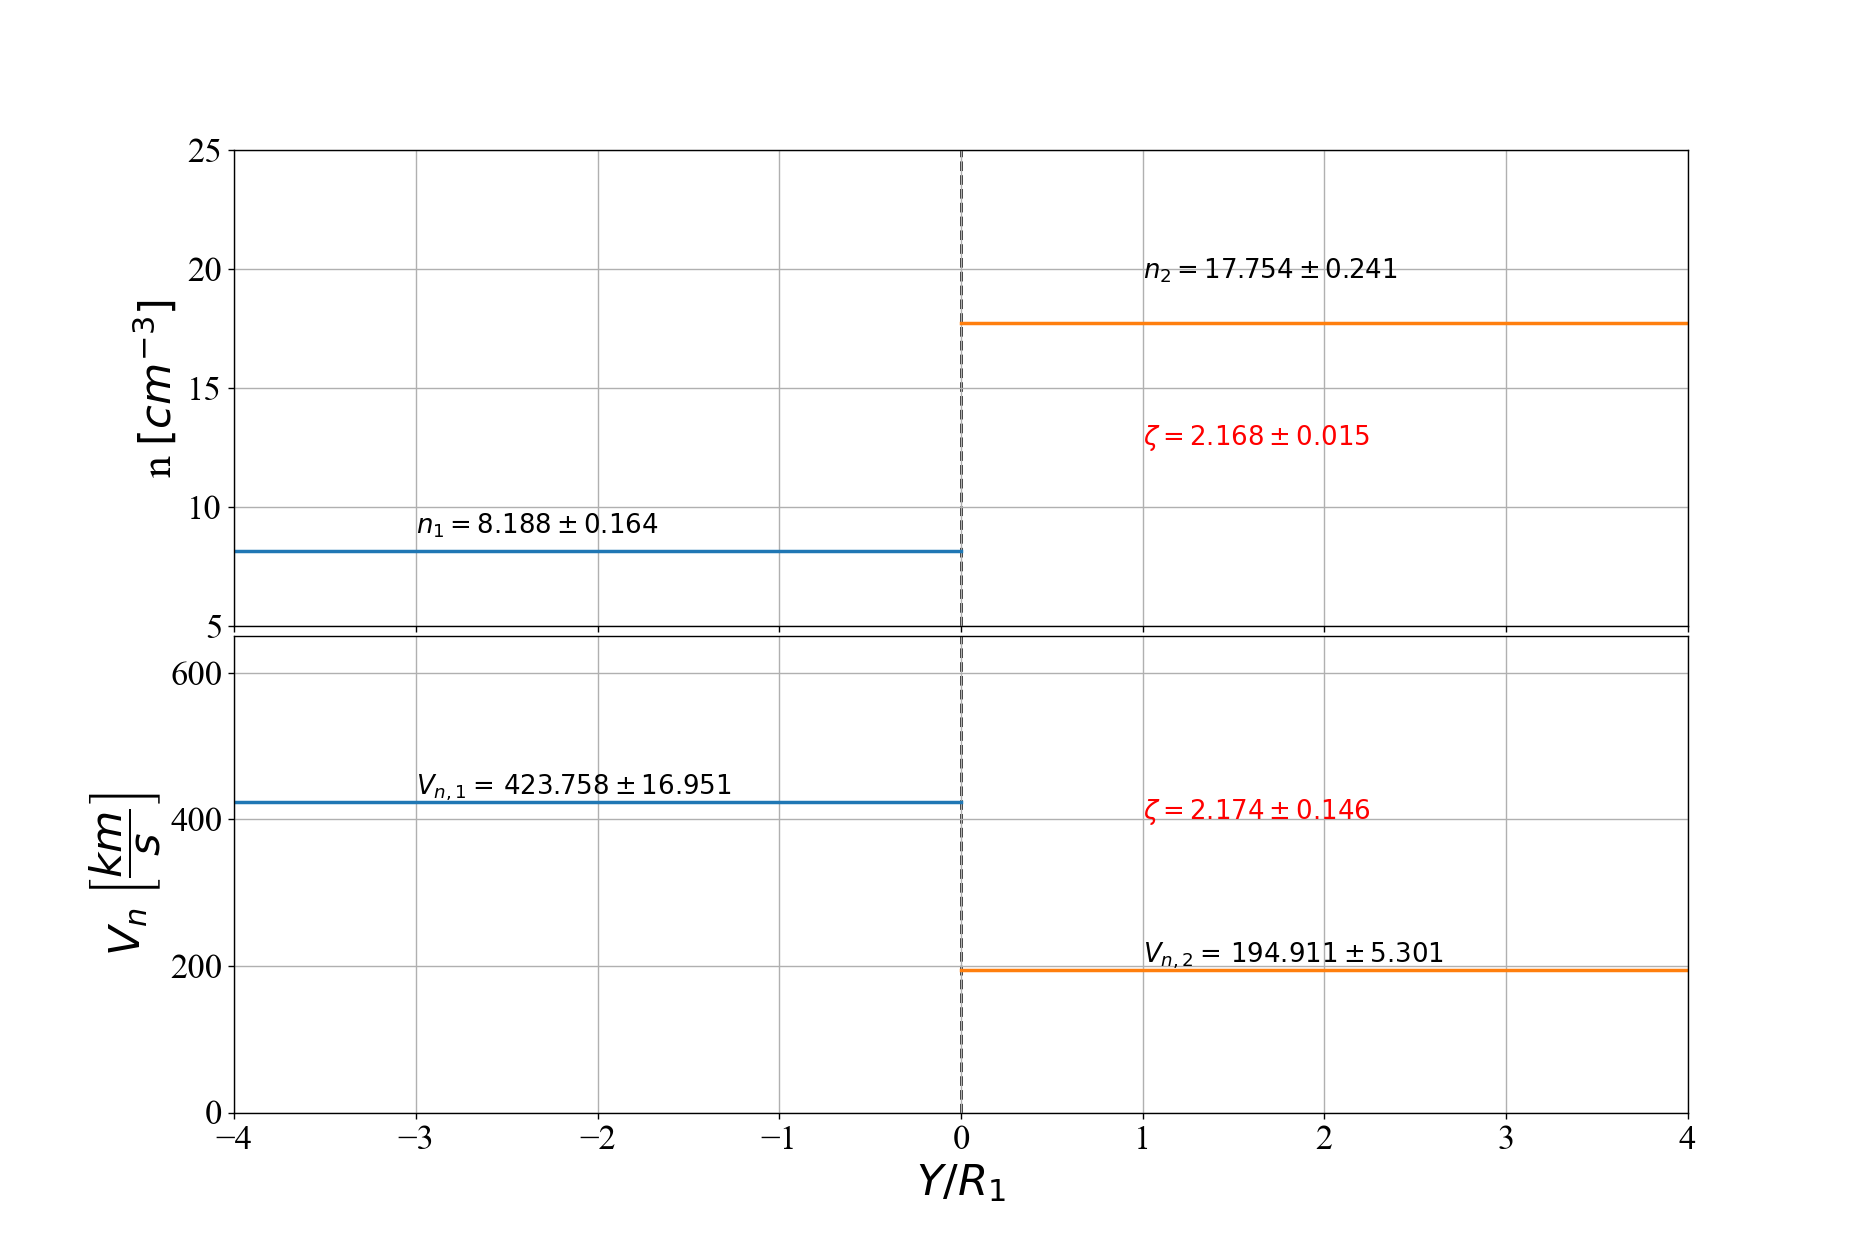

In [63]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)} \pm {round(err_up,3)}$',    xy= (-3,8.9), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}$',    xy= (1,19.6), size=15)  
ax[0].annotate(f'$\zeta   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,12.6), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[ cm^{-3} \right]$', size=25)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)
ax[0].grid(axis='both')
ax[0].set_ylim([5,25])
ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=20)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate("$V_{n,1}$" + f'$ =  \, {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}$',    xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate("$V_{n,2}$" + f'$ =  \, {round(v_dw*1e2,3)} \pm {round(Del_vdw*1e2,3)}$',    xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$\zeta   = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$V_n$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=25)
ax[1].set_xlabel(r'$Y/R_1$', size=25)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=20)  
#ax[1].set_aspect(1)

plt.savefig('MonteCarloParametrosfisicos_01122015.png', bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

## Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [53]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [54]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [55]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95      8.308312
-3.85      8.268261
-3.75      8.267043
-3.65      8.267011
-3.55      8.264060
            ...    
 19.55    18.070927
 19.65    18.040172
 19.75    17.868083
 19.85    17.926832
 19.95    17.821368
Name: mean, Length: 240, dtype: float64

<IPython.core.display.Javascript object>


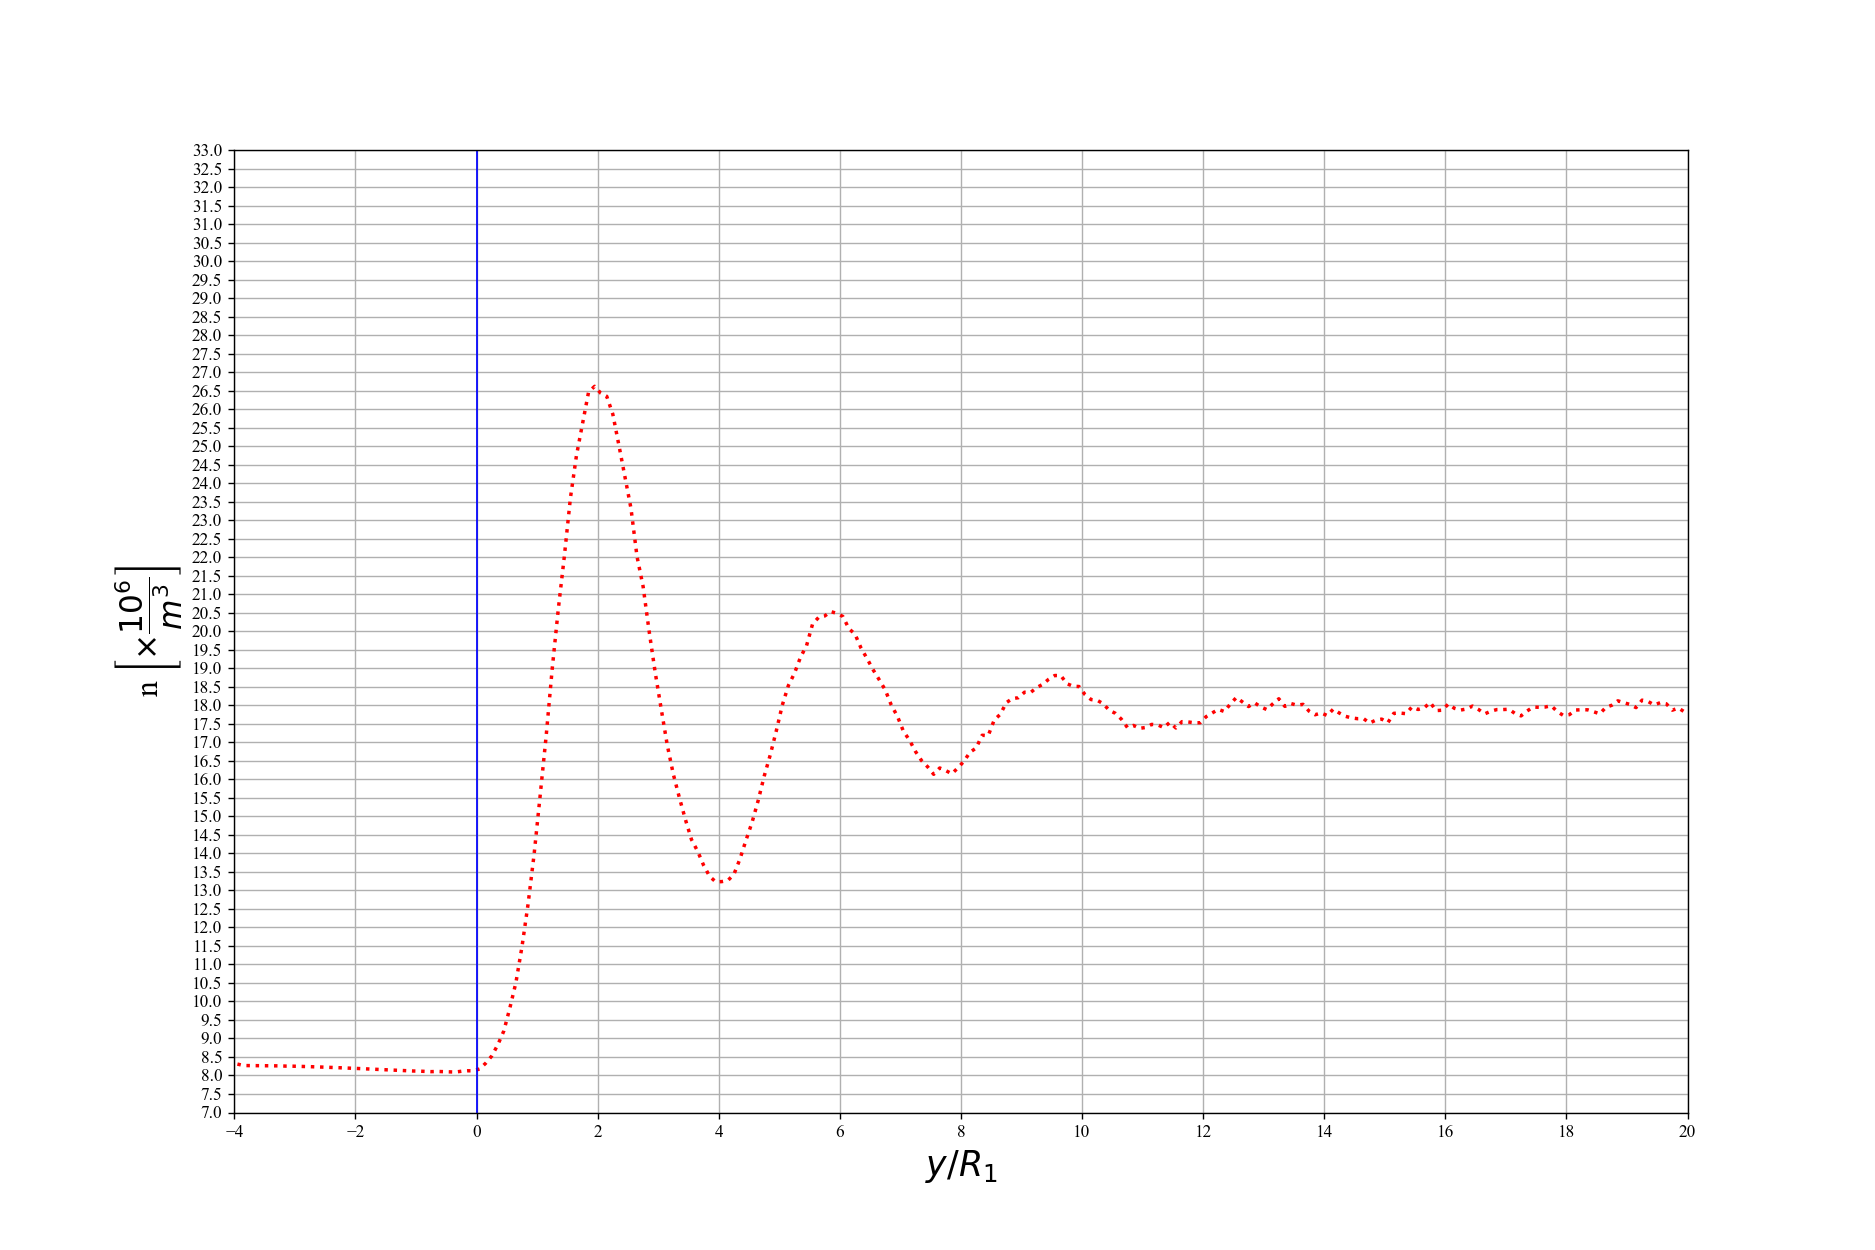

In [56]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,20])
ax.set_xticks(np.arange(-4,20.1,2))
ax.set_yticks(np.arange(7,33.1,0.5))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()

In [57]:
v1

[-500.7491, 52.872524, -17.03108]

In [58]:
V2 = [-161.46,   70.09,   -88.45]    

In [59]:
V2n = np.abs(np.dot(V2,n)*1e3) 
round(V2n,3)

103947.319

In [60]:
n

[0.8855696, -0.0281544, -0.4636528]